In [ ]:
import os
files = os.listdir('../input')
print('trainLabels.csv' in files) #Is the labels csv in the directory?
print(len(files)) #There should be 1000 images + 1 csv file = 1001 files

True
1001


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
!pip install fastai==1.0.42

    100% |████████████████████████████████| 163kB 6.9MB/s 
  Found existing installation: fastai 1.0.45
    Uninstalling fastai-1.0.45:
      Successfully uninstalled fastai-1.0.45
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
from fastai import *
from fastai.vision import *
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
print('Make sure cuda is installed:', torch.cuda.is_available())
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

Make sure cuda is installed: True
Make sure cudnn is enabled: True


# Reading data
Here I am going to open the dataset with pandas, check distribution of labels, and oversample to reduce imbalance.

In [ ]:
base_image_dir = os.path.join('..', 'input')
df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))
df['path'] = df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
df['exists'] = df['path'].map(os.path.exists) #Most of the files do not exist because this is a sample of the original dataset
df = df[df['exists']]
df = df.drop(columns=['image','exists'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(10)

,level,path
0,2,../input/155_right.jpeg
1,0,../input/102_left.jpeg
2,0,../input/428_right.jpeg
3,0,../input/1161_right.jpeg
4,1,../input/231_left.jpeg
5,2,../input/752_right.jpeg
6,0,../input/554_left.jpeg
7,0,../input/800_right.jpeg
8,0,../input/554_right.jpeg
9,0,../input/863_left.jpeg


The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels. 

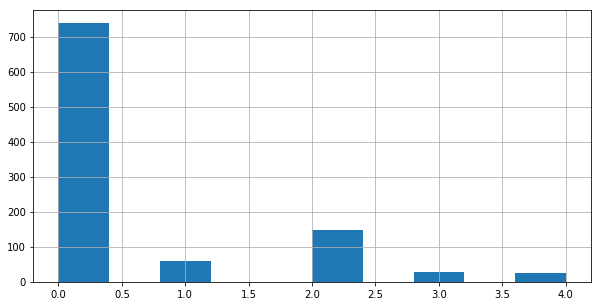

In [ ]:
df['level'].hist(figsize = (10, 5))

In [ ]:
df.pivot_table(index='level', aggfunc=len)

,path
level,
0,739
1,59
2,148
3,28
4,26


This is a function to oversample the dataset (so some of the images of levels 1-4 are present multiple times in the dataset):

In [ ]:
def balance_data(class_size,df):
    train_df = df.groupby(['level']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['level'].hist(figsize = (10, 5))
    return train_df

In [ ]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df,test_size=0.2) # Here we will perform an 80%/20% split of the dataset, with stratification to keep similar distribution in validation set

200

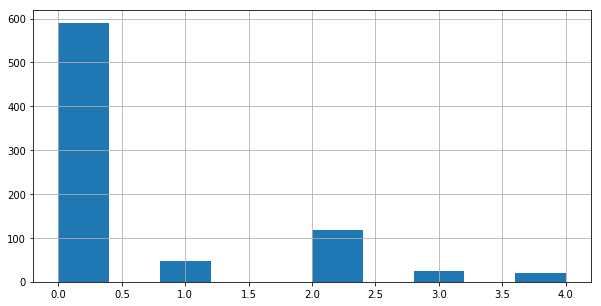

In [ ]:
train_df['level'].hist(figsize = (10, 5))
len(val_df)

In [ ]:
train_df.pivot_table(index='level', aggfunc=len)

,path
level,
0,590
1,47
2,119
3,24
4,20


New Data Size: 2950 Old Size: 800


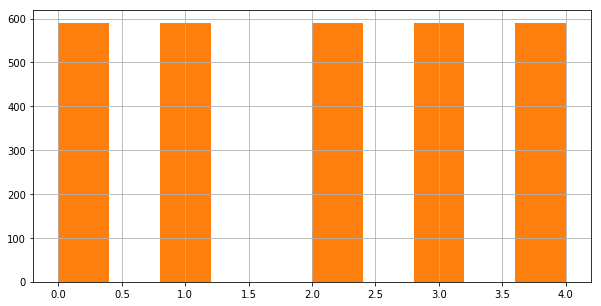

In [ ]:
train_df = balance_data(train_df.pivot_table(index='level', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['level'].hist(figsize = (10, 5))

In [ ]:
df = pd.concat([train_df,val_df]) #beginning of this dataframe is the oversampled training set, end is the validation set
len(df)

3150

In [ ]:
from PIL import Image

im = Image.open(train_df['path'][1])
width, height = im.size
print(width,height) 

3888 2592


The images are actually quite big. We will resize to a much smaller size and try to use progressive resizing to our advantage when dealing with such a small dataset.

In [ ]:
bs = 16 #smaller batch size is better for training, but may take longer
sz=224

Here, I load the dataset into the `ImageItemList` class provided by `fastai`. The fastai library also implements various transforms for data augmentation to improve training. While there are some defaults that I leave intact, I add vertical flipping (`do_flip=True`) and 360 deg. `max_rotate=360` as those have been commonly used for this particular problem.

Typically, one would use the `ImageDataBunch` class to load the dataset much easier, but since I needed to do some custom tasks for splitting and oversampling, I have to use this customized creation of the DataBunch.

In [ ]:
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
src = (ImageItemList.from_df(df=df,path='./',cols='path') #get dataset from dataset
        .split_by_idx(range(len(train_df)-1,len(df))) #Splitting the dataset
        .label_from_df(cols='level') #obtain labels from the level column
      )
data= (src.transform(tfms,size=sz) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

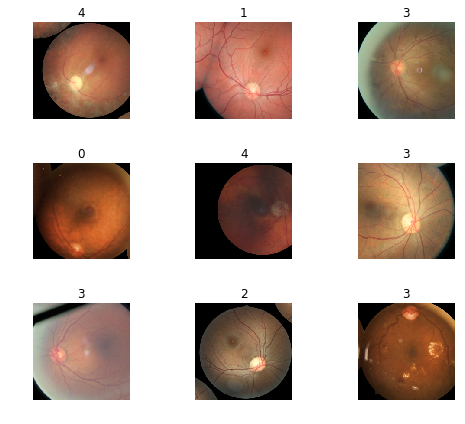

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

We can see that because of the center cropping and data augmentation, some of the images are cut off or have weird artifacts. This is probably because the fundus image was not 100% centered in the original data. For now, I will ignore these problems.

In [ ]:
print(data.classes)
len(data.classes),data.c

[0, 1, 2, 3, 4]


(5, 5)

# Training (Transfer learning) 

We used Cohen's quadratically weighted kappa , This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [ ]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.argmax(y_hat,1), y, weights='quadratic'),device='cuda:0')

**Training:**

We use transfer learning, where we retrain the last layers of a pretrained neural network. I use the ResNet50 architecture trained on the ImageNet dataset, which has been commonly used for pre-training applications in computer vision. Fastai makes it quite simple to create a model and train:

In [ ]:
import torchvision
learn = create_cnn(data, models.resnet50, metrics = [accuracy,quadratic_kappa])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 22136277.75it/s]


We use the learning-rate finder developed by Dr. Leslie Smith and implemented by the fastai team in their library:

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


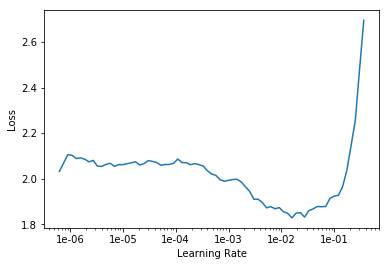

In [ ]:
learn.recorder.plot()

Here we can see that the loss decreases fastest around `lr=2e-3` so that is what we will use to train: 

In [ ]:
learn.fit_one_cycle(4,max_lr = 2e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,1.188898,1.689337,0.358209,0.205384
2,0.740812,1.213346,0.472637,0.336173
3,0.528743,1.082347,0.542289,0.388561
4,0.395779,0.989219,0.572139,0.432191


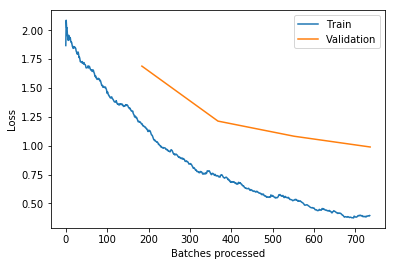

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-224')

The previous model only trained the last model. We can unfreeze the rest of the model, and train the rest of the model using discriminative learning rates. The first layers aren't changed as much, with lower learning rates, while the last layers are changed more, with higher learning rates. We use the learning rate finder again, and use a range of learning rates for different layers in the neural network.

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


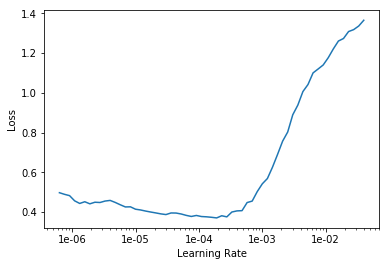

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.368139,1.112008,0.552239,0.402208
2,0.325955,0.998572,0.611940,0.454725
3,0.304568,0.954659,0.641791,0.465407
4,0.247033,1.000449,0.626866,0.458941


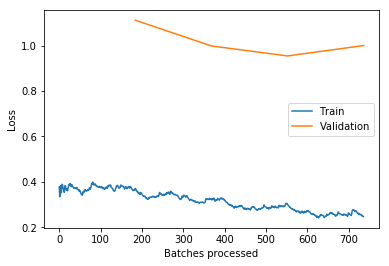

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-224')

# Progressive resizing

Progressive resizing is a technique developed by Jeremy Howard as part of the fast.ai class and for the [DAWNBench challenge](https://www.fast.ai/2018/08/10/fastai-diu-imagenet/). The idea is that we train with smaller images at the beginning, and retrain with larger images, which will have more information to learn from. This could be very helpful for dealing with small datasets, and I decided to give this a try. I only resize once due to kernel time limitations, but theoretically, we could continue to resize and see if that improves accuracy, especially since the retinal images are so big in size.

In [ ]:
data = (src.transform(tfms,size=sz*2) #Data augmentation
        .databunch(bs=bs,num_workers=0) #DataBunch
        .normalize(imagenet_stats) #Normalize
       )

In [ ]:
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 448, 448])

In [ ]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


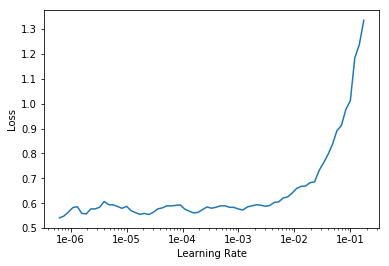

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4,max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.437581,0.908528,0.631841,0.425630
2,0.361834,0.906351,0.661692,0.519596
3,0.243277,0.841538,0.686567,0.538385
4,0.196001,0.822923,0.686567,0.503841


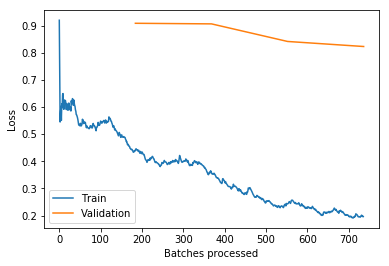

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-1-448')

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


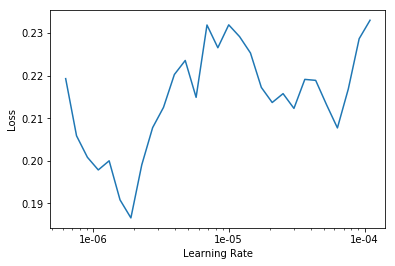

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,quadratic_kappa
1,0.173685,0.770790,0.721393,0.512298
2,0.180332,0.792204,0.706468,0.537599
3,0.143606,0.700847,0.751244,0.586596
4,0.125539,0.733166,0.751244,0.571582


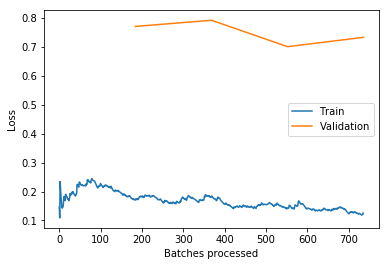

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-448')

# Checking results

We look at our predictions and make a confusion matrix.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

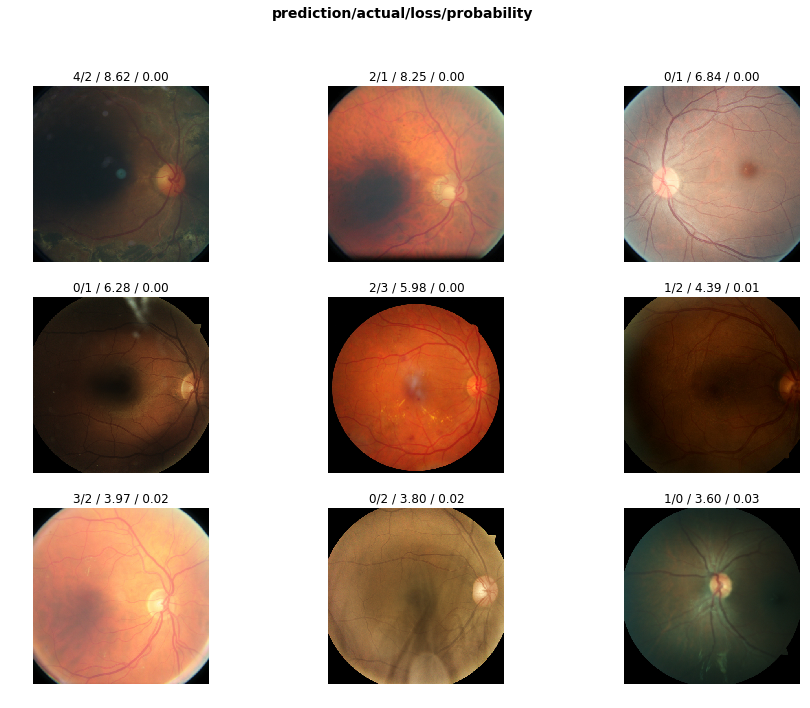

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))

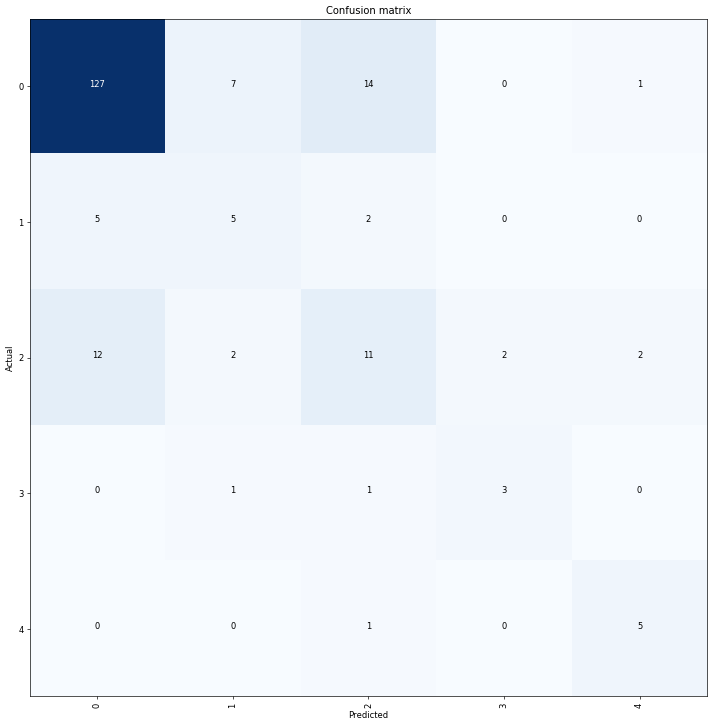

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Quite impressively, with only 1000 images, oversampling, and transfer learning, we acheive decent agreement with the correct labels! 